In [2]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
%matplotlib inline
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:80% !important; }</style>")) 

In [2]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

### Import custom-built probabilistic matrix factorization (PMF) module

In [3]:
cwd = os.getcwd()
path = os.path.join(cwd, '..', 'src')
if not path in sys.path:
    sys.path.append(path)
del cwd, path
import PMF

In [ ]:
reload(PMF)

### Load data (FIRST SESSION ONLY - see below for depersist)

In [267]:
cwd = os.getcwd()
movies = pd.read_csv(os.path.join(cwd, "..", "data", "movies.csv"))

In [268]:
movies.shape

(27278, 3)

In [269]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [25]:
movies_backup = movies.copy()

### Accept user input

In [136]:
from ipywidgets import widgets

In [137]:
def handle_submit(sender):
    global movieid
    if text.value != '':
        user[movieid] = text.value
    clear_output()
    movieid = show_movie()
    text.value = ''

In [138]:
def show_movie():
    global movies
    movie = movies.sample(1)
    movies = movies.drop(movie.index)
    print('number of movies unrated: ' + str(movies.shape[0]) + '\n')
    print(movie)
    return movie['movieId'].values[0]

In [ ]:
text = widgets.Text()
random_state = 14113
display(text)
text.on_submit(handle_submit)

movieid = show_movie()

### Persist user profile data after session is complete

In [4]:
print('Profile was last updated: ' + str(datetime.datetime.now()))
print('Number of movies rated: ' + str(len(user)))
print('Number of movies to go: ' + str(movies.shape[0]))

Profile was last updated: 2017-08-08 12:48:49.604464
Number of movies rated: 612
Number of movies to go: 0


In [233]:
movies.to_csv('movies_to_be_rated.csv')
pickle.dump(user, open('adam_ratings.pkl', "wb"))

### Depersist before starting a new session

In [3]:
movies = pd.read_csv('movies_to_be_rated.csv', encoding="ISO-8859-1", index_col=0)
user = pickle.load(open('adam_ratings.pkl', 'rb'))

In [9]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller


## Filter for movies I have likely seen
It's going to take a _very_ long time to rate 27,000 movies. Try to reduce this number by filtering movies on:
1. Movie name string length. Some of the foreign movies have a very long titles
2. Date released. This would require parsing the title string for the year
3. Rating frequency. I probably haven't seen the movies that have only a few ratings. If I could order them by how many times they've been rated it could help me find the ones I've seen quicker. This frequency data would be available in the other notebook, but that script is running for a long time and might never finish.

### Movie name string length

In [270]:
title_lens = movies.apply(lambda x: len(x['title']) , axis=1)

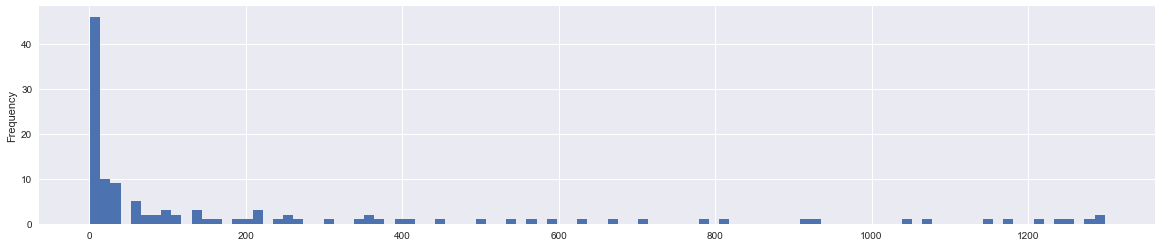

In [271]:
plt.rcParams['figure.figsize'] = (20, 4)
title_lens.value_counts().plot(kind='hist', bins=100)

In [344]:
(title_lens < 60).sum(), len(title_lens)

(26184, 27278)

In [345]:
mask_title_length = title_lens < 60

In [346]:
len('Lord of the Rings: The Fellowship of the Ring (xxxx)')

52

### Non english words in title

#### Get a set of english words from the internet
http://www-01.sil.org/linguistics/wordlists/english/wordlist/wordsEn.txt

In [275]:
wordsEn = set(line.strip() for line in open('wordsEn.txt'))

In [276]:
len(wordsEn)

109583

#### Deem a movie title not English if more than 2 words are not in the set of English words `wordsEn`

In [277]:
import string

In [278]:
def check_if_english(row):
    title = row['title'].lower()
    title = ''.join(c for c in title if c not in set(string.punctuation)).strip()
    title = ''.join(c for c in title if not c.isdigit()).strip()
    words = title.split(' ')
    count = 0
    for word in words:
        if word.strip() not in wordsEn:
            count += 1
            if count >= 2:
                return False
    return True

In [279]:
is_en = movies.apply(check_if_english, axis=1)

In [280]:
is_en.sum(), len(is_en)

(22694, 27278)

In [281]:
mask_isenglish = is_en

### Release year

In [282]:
import re

In [283]:
def get_release_year(row):
    title = row['title']
    year = re.search(r'\(\d{4}\)', title)
    if year:
        year = year.group(0)
    else:
        return None
    year = int(year.replace('(', '').replace(')', ''))
    return year

In [284]:
release_year = movies.apply(get_release_year, axis=1)

In [285]:
len(release_year) - len(release_year.dropna())

22

In [286]:
fig_dims1 = (20, 6)

C:\ProgramData\Anaconda2\envs\py35\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


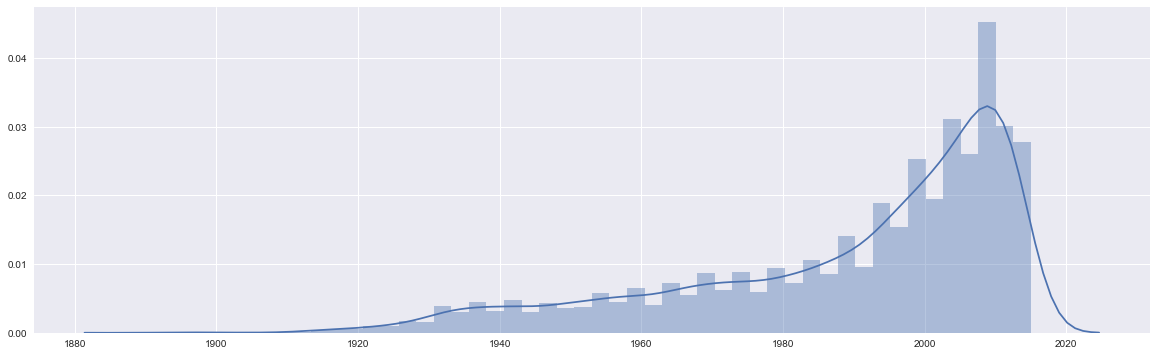

In [287]:
fig, ax = plt.subplots(figsize=fig_dims1)
sns.distplot(release_year.dropna(), ax=ax)

In [288]:
(release_year > 1990).sum(), len(release_year)

(16804, 27278)

In [289]:
mask_release_year = (release_year > 1990)

### Rating frequency

In [309]:
cwd = os.getcwd()
ratings = pd.read_csv(os.path.join(cwd, "..", "data", "ratings.csv"))

In [369]:
ratings.shape

(20000263, 4)

In [370]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [371]:
freq = ratings['movieId'].value_counts()

In [372]:
freq.head()

296    67310
356    66172
318    63366
593    63299
480    59715
Name: movieId, dtype: int64

In [373]:
freq.describe()

count    26744.000000
mean       747.841123
std       3085.818268
min          1.000000
25%          3.000000
50%         18.000000
75%        205.000000
max      67310.000000
Name: movieId, dtype: float64

In [376]:
thresh = 200

In [377]:
(freq >= thresh).sum()

6757

In [378]:
red_freq = freq[freq >= thresh]

In [379]:
red_freq = red_freq.index.tolist()

In [380]:
red_freq[:10]

[296, 356, 318, 593, 480, 260, 110, 589, 2571, 527]

In [381]:
mask_freq = movies['movieId'].isin(red_freq)

### Combine masks

In [382]:
mask_isenglish.sum(), mask_release_year.sum(), mask_title_length.sum(), mask_freq.sum()

(22694, 16804, 26184, 4055)

In [383]:
mask = mask_isenglish & mask_release_year & mask_title_length & mask_freq

In [384]:
mask.sum()

4055

In [385]:
cwd = os.getcwd()
movies = pd.read_csv(os.path.join(cwd, "..", "data", "movies.csv"))

In [386]:
movies.shape

(27278, 3)

In [387]:
movies = movies[mask]

In [388]:
movies.shape

(4055, 3)

In [389]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [362]:
movies['movieId'].nunique()

4986

In [390]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [391]:
ratings.shape

(20000263, 4)

In [392]:
ratings_red = pd.merge(ratings, movies[['movieId']], on='movieId')

In [393]:
ratings_red.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,5,2,3.0,851527569
2,13,2,3.0,849082742
3,29,2,3.0,835562174
4,34,2,3.0,846509384


In [394]:
ratings_red.shape

(12391806, 4)

# Explore and Clean my Ratings Profile

In [238]:
# unique rating values
set(user.values())

{'1', '2', '3', '4', '5', '6'}

In [241]:
user_temp = [(int(k), int(v)) for k,v in user.items()]

In [242]:
user_temp

[(1, 4),
 (33794, 5),
 (2053, 2),
 (102407, 5),
 (3081, 4),
 (3082, 5),
 (69644, 4),
 (6157, 4),
 (54286, 5),
 (56152, 2),
 (47122, 3),
 (19, 5),
 (52245, 4),
 (77846, 4),
 (30825, 4),
 (57368, 4),
 (42009, 4),
 (97306, 4),
 (42011, 4),
 (111644, 4),
 (30749, 3),
 (100383, 4),
 (105504, 5),
 (2082, 5),
 (1060, 5),
 (74789, 3),
 (3114, 4),
 (3752, 4),
 (8969, 1),
 (30894, 3),
 (1544, 5),
 (93363, 3),
 (4148, 5),
 (126008, 4),
 (104, 5),
 (4447, 1),
 (116797, 5),
 (5299, 3),
 (88129, 5),
 (102125, 5),
 (56775, 5),
 (1095, 5),
 (524, 4),
 (3146, 4),
 (3147, 5),
 (88140, 5),
 (57421, 4),
 (5816, 5),
 (7254, 5),
 (116823, 2),
 (88, 3),
 (30812, 5),
 (1722, 5),
 (5218, 4),
 (6502, 4),
 (3176, 5),
 (56367, 4),
 (64620, 4),
 (59501, 4),
 (110, 5),
 (67923, 5),
 (49272, 5),
 (127098, 5),
 (8866, 4),
 (69757, 4),
 (51935, 4),
 (111743, 4),
 (4226, 5),
 (5995, 4),
 (110102, 5),
 (364, 4),
 (111759, 5),
 (85131, 3),
 (4369, 5),
 (6287, 5),
 (97304, 5),
 (4242, 4),
 (56174, 5),
 (150, 5),
 (4247, 3

In [244]:
user = dict(user_temp)

In [245]:
user

{1: 4,
 10: 5,
 19: 5,
 32: 5,
 47: 5,
 88: 3,
 104: 5,
 110: 5,
 150: 5,
 165: 5,
 194: 4,
 216: 5,
 231: 5,
 253: 3,
 260: 5,
 296: 5,
 318: 4,
 329: 4,
 333: 3,
 344: 5,
 364: 4,
 393: 2,
 420: 3,
 457: 5,
 480: 5,
 500: 3,
 524: 4,
 539: 3,
 553: 5,
 588: 4,
 589: 5,
 593: 5,
 648: 5,
 672: 3,
 673: 3,
 711: 2,
 736: 4,
 778: 5,
 784: 2,
 888: 3,
 1005: 3,
 1060: 5,
 1095: 5,
 1265: 3,
 1291: 5,
 1320: 5,
 1356: 4,
 1479: 4,
 1485: 5,
 1527: 4,
 1544: 5,
 1573: 4,
 1588: 3,
 1590: 3,
 1608: 5,
 1631: 4,
 1644: 3,
 1682: 5,
 1704: 5,
 1721: 4,
 1722: 5,
 1732: 5,
 1777: 4,
 1797: 5,
 1801: 3,
 1882: 3,
 1889: 4,
 1907: 3,
 1918: 4,
 2006: 4,
 2021: 4,
 2028: 5,
 2042: 4,
 2053: 2,
 2082: 5,
 2153: 5,
 2231: 4,
 2294: 2,
 2335: 4,
 2340: 4,
 2353: 5,
 2355: 3,
 2424: 4,
 2459: 4,
 2502: 5,
 2571: 5,
 2605: 4,
 2617: 4,
 2628: 5,
 2683: 4,
 2694: 5,
 2701: 3,
 2706: 4,
 2710: 4,
 2712: 4,
 2761: 3,
 2762: 4,
 2858: 4,
 2959: 5,
 3007: 3,
 3081: 4,
 3082: 5,
 3100: 4,
 3114: 4,
 3146: 

In [249]:
for k, v in user.items():
    if v == 6:
        user[k] = 5

In [250]:
set(user.values())

{1, 2, 3, 4, 5}

In [255]:
pd.Series(list(user.values())).value_counts()

5    260
4    215
3    107
2     24
1      6
dtype: int64

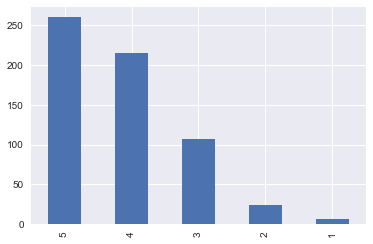

In [256]:
pd.Series(list(user.values())).value_counts().plot(kind='bar')

In [261]:
user_df = pd.DataFrame(list(user.items()), columns=['movieId', 'rating'])

In [262]:
user_df.head()

,movieId,rating
0,1,4
1,33794,5
2,3755,5
3,2053,2
4,102407,5


In [263]:
user_df.to_csv('adam_profile.csv')

In [264]:
test = ['a', 'b', 'c']

In [266]:
test[]

'b'